# Exercício 1: Ações e Commodities
###  Implementando Uma Estratégia Replicante 
<sub>Uirá Caiado. 11 de Maio, 2016<sub>

#### Resumo

_Neste projeto vou implementar uma estratégia de hedging dinâmico auto-financiável que replique o payoff de diferentes derivativos. Devido à natureza aleatória do ativo objeto dos contratos testados, este será modelado como um processo estocástico. Uma vez implementado o modelo, será realizada um série de simulações para estudar a efetividade da estratégia._

## 1. Introdução

Nesta sessão dou uma breve descrição do que é uma EDE e declaro o problema que será abordado.

### 1.1. Equações Diferenciais Estocásticas

Devido à incerteza inerente ao mercado financeiro, é necessário levar em conta uma flutuação aleatória nos modelos criados para descrever diferentes instrumentos. Para tanto, frequentemente assume-se o comportamento de um ativo como sendo um [processo estocático](https://en.wikipedia.org/wiki/Stochastic_process). 

Como bem explicado neste [post](http://math.stackexchange.com/questions/1470686/in-laymans-terms-what-is-a-stochastic-process), um processo estocástico é uma maneira de representar como alguma coisa se desenvolve ao longo do tempo. A cada unidade de tempo, o ativo pode assumir uma de muitas posições possíveis, e cada uma destas posições tem uma probabilidade associada. Ainda que não seja possível antecipar qual trajeto o ativo vai seguir, é possível inferir quais caminhos são possíveis baseado nesta dinâmica.

Processos estocásticos são de grande valia quando não se sabe exatamente as regras que regem esta evolução ou quando extrair tais regras com exatidão ou é muito complicado ou muito caro computacionalmente. Assim, frequentemente se utiliza alguma fonte de aleatoriadade para ajudar a descrever a dinâmica de um ativo. Aqui entram as EDEs. \cite{Wilmont} oferece a seguinte intuição sobre a forma geral de Equações Diferenciais Estocásticas (EDE):

$$\mathrm{d}\, Alguma\,Coisa = Deterministico\,\mathrm{d}t + Aleatório\,\mathrm{d}X $$


Onde $Alguma\,Coisa$ é o que se quer modelar (como preço de uma ação, quantidade de pessoas chegando em um hospital e etc), $Deterministico$ uma função que descreve como  $Alguma\,Coisa$ muda quando se retira a incerteza e $Aleatório$ outra função que descreve quão incerto $Alguma\,Coisa$ coisa é e $X$ é uma variável aleatória que pode ter distribuição Normal Padrão, por exemplo.

### 1.1. O Problema

Considerando um ativo-objeto cujo a dinâmica do preço satisfaz a seguinte EDE:

$$\frac{\mathrm{d} S_t}{S_t}=\mu\cdot \mathrm{d}t + \sigma\cdot \mathrm{d}W_{t}$$

Será vendido um derivativo com característica européia cujo payoff é descrito por uma função qualquer $V_T=V(T, S_T)$, onde $T$ é o vencimento do derivativo. $S_T$ é o preço do ativo-objeto em $T$ e é possível negociar qualquer quantidade dele em qualquer instante. Não há custo de transação (corretagem, emolumento, bid-ask spread, etc) e posições vendidas a descoberto no subjacente são permitidas, não havendo custos associados.

Pede-se que se implemente uma estratégia dinâmica de hedging auto-financiável que replique o payoff do derivativo vendido. A estratégia replicante será rebalanceada $N$ vezes (incluíndo a carteira inicial).

A simulação deve ser feita para os payoffs abaixo. $K$ é o Strike da opção.
- $V(T, S_T)=ln(S_T)$
- $V(T, S_T)=(ln(S_T))^2$
- $V(T, S_T)=(S_T-K)^2$
- $V(T, S_T)=\mathbf{1}_{S_T > K}$
- $V(T, S_T)=max(S_T-K, 0)$


## 2. Definições

Nesta sessão vou calcular a solução analítica das opções sugeridas na última sessão e discretizar o a dinâmica do ativo objeto 

### 2.1. Discretizando o Processo Estocástico

Para realizar a simulação, implementarei o processo estocástico do ativo-objeto, que segue um Movimento Browniano Geométrico. Desta forma, preciso discretizar o processo e tenho duas opções para isso: ou encontro a solução para a EDE porposta, que resultará no [processo estocástico desejado](https://en.wikipedia.org/wiki/Geometric_Brownian_motion); ou uso [método de Euler](http://www.columbia.edu/~mh2078/MCS04/MCS_SDEs.pdf). O último, apesar de ser apenas uma aproximação do processo, tem a a vantagem de poder ser aplicada à qualquer Equação diferencial Estocástica (\cite{Wilmont}).

Inicialmente, vou mostrar a solução da EDE e depois como posso ustilizar Euler. Assim, seguindo as notas de aula, tenho a minha dinâmica como sendo

\begin{equation}
    \begin{aligned}
    \frac{\mathrm{d} S_t}{S_t} &= \mu\cdot \mathrm{d}t + \sigma\cdot \mathrm{d}W_{t}
    \end{aligned}
\end{equation}


Que corresponde a forma derivada da integral estocástica:


\begin{equation}
    \begin{aligned}
    \int_{t}^{T}{\frac{\mathrm{d} S_t}{S_t}} &= \int_{t}^{T}{\mu\cdot \mathrm{d}t} + \int_{t}^{T}{\sigma\cdot \mathrm{d}W_{t}} 
    \end{aligned}
\end{equation}



Considerando o [Teorema de Ito-Doeblin](https://en.wikipedia.org/wiki/Itô%27s_lemma) (Lemma de Ito) sendo da forma abaixo

\begin{equation}
    \begin{aligned}
    \mathrm{d} f(t, S_t) = \frac{\mathrm{\partial} f}{\partial t} \mathrm{d} t + \frac{\mathrm{\partial} f}{\partial S_t} \mathrm{d} S_t + \frac{1}{2} \frac{\mathrm{\partial^2} f}{\mathrm{\partial} S_{t}^{2}} (\mathrm{d} S_t)^2
    \end{aligned}
\end{equation}

Se definir uma função $f(S_t) = ln(S_t)$, posso aplicar o Lema de Ito sobre ela. Dado que $(\mathrm{d} t)^2 = \mathrm{d} t \cdot \mathrm{d} X = 0$, e que $(\mathrm{d} S_t)^2 = \sigma^2  \cdot S_{t}^{2} \cdot \mathrm{d} t$. Como não há termos dependentes de $t$ em $f$, não precisarei do termo relacionado a $\mathrm{d} t$. Assim ficou com:

\begin{equation}
    \begin{aligned}
    \mathrm{d} f(t, S_t) &= \frac{\mathrm{\partial} f}{\partial S_t} \mathrm{d} S_t + \frac{1}{2} \frac{\mathrm{\partial^2} f}{\mathrm{\partial} S_{t}^{2}} (\mathrm{d} S_t)^2 \\
    &= \frac{1}{S_t} \cdot \mathrm{d} S_t - \frac{\sigma^2}{2} \cdot S_{t}^{2} \cdot \frac{1}{S_{t}^{2}} \cdot  \mathrm{d} t 
    \end{aligned}
\end{equation}

Integrando dos instantes $t$ até $T$, obtenho:

\begin{equation}
    \begin{aligned}
    \int_{t}^{T} \mathrm{d} f(t, S_t) &= \int_{t}^{T} \frac{1}{S_t} \cdot \mathrm{d} S_t - \int_{t}^{T} \frac{\sigma^2}{2} \cdot \mathrm{d} t \\
    \int_{t}^{T} \frac{\mathrm{d} S_t}{S_t} &= \int_{t}^{T} \mathrm{d} f(t, S_t) + \int_{t}^{T} \frac{\sigma^2}{2} \cdot \mathrm{d} t \\
    &= f(S_T) - f(S_t) + \frac{\sigma^2}{2} \cdot (T - t) \\
    &= ln(S_T) - ln(S_t) + \frac{\sigma^2}{2} \cdot (T - t) \\
    &= ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t)
    \end{aligned}
\end{equation}

Logo, substituíndo este resultado na integral estocástica da dinâmica da ação, chego que:

\begin{equation}
    \begin{aligned}
    ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \int_{t}^{T}{\mu\cdot \mathrm{d}t} + \int_{t}^{T}{\sigma\cdot \mathrm{d}W_{t}} \\
     ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \mu\cdot (T - t) + \sigma \cdot (W_{T} - W_{t})
    \end{aligned}
\end{equation}

Por fim, lembrando que o $W_t$ é um processo de Winer e possui incrementos independentes, estacionários e distribuição $N(0, t)$ por definição, posso considerar que $W_t - W_s = W_{t-s}$. Termino com:

\begin{equation}
    \begin{aligned}
     ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \mu\cdot (T - t) + \sigma \cdot W_{T-t} \\
     ln(S_T/S_t) &= \left (\mu - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W_{T-t} \\
     S_T &= S_t \cdot e^{ \left (\mu - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W_{T-t}}
    \end{aligned}
\end{equation}

Onde $W_{T-t} = \sqrt{T-t} \cdot \epsilon_t$. A última equação é a solução exata desta EDE e poderia ser utilizada na simulação. Porém, em aplicações reais muitas vezes a equação estocástica pode não ter uma solução explícita ou podemos ter dificuldade em determinar os parâmetros do modelo ou a distribuição de $W_{t}$. Assim, muitas vezes recorre-se ao método de Euler para discretizar o processo. Neste caso, o método é da forma:
\begin{equation}
    \begin{aligned}
    \hat{X}_{t_i} = b(t, \hat{X}_{t_i}) \cdot h_i + \sigma(t_i, \hat{X}_{t_i}) \cdot \sqrt{h_i} \cdot \epsilon_i\\
    \left\{\begin{matrix}
        b(t, \hat{X}_{t_i}) &= \mu S_{t_{i}}\\ 
        \sigma(t_i, \hat{X}_{t_i}) &= \sigma S_{t_{i}}\\ 
        h_i &= t_{i+1} - t_i
    \end{matrix}\right.
    \end{aligned}
\end{equation}

Sendo que $\epsilon$ é uma variável aleatória com distribuição normal padrão. Isso é tudo que preciso para simulação. Abaixo, plotei 5 simulações utilizando cada um dos métodos acima:

In [1]:
def convert_to_prices(param, log_returns):
    """
    This method converts a sequence of log returns into normal returns (exponentiation) and then computes a price
    sequence given a starting price, param.all_s0.
    :param param: the model parameters object
    :param log_returns: the log returns to exponentiated
    :return:
    """
    returns = numpy.exp(log_returns)
    # A sequence of prices starting with param.all_s0
    price_sequence = [param.all_s0]
    for i in range(1, len(returns)):
        # Add the price at t-1 * return at t
        price_sequence.append(price_sequence[i - 1] * returns[i - 1])
    return numpy.array(price_sequence)

In [18]:
nrand.normal?

In [27]:
import math
import numpy
import random
import decimal
import scipy.linalg
import numpy
import numpy.random as nrand
import pandas as pd

def wiener_process(f_sigma, f_delta_time, f_steps):
    """
    This method returns a Wiener process. The Wiener process is also called Brownian motion.
    :param f_sigma: float. The standard deviation of the distribution
    :param f_delta_time: float. the time at each step in years
    :param f_steps: float. number of steps to simulate for
    :return: numpy array. brownian motion log returns
    """
    dt = f_delta_time/f_steps
    sqrt_delta_sigma = math.sqrt(dt) * f_sigma
    return numpy.array(nrand.normal(loc=0, scale=sqrt_delta_sigma, size=int(f_steps)))



In [28]:
def geometric_brownian_motion(f_init_price, f_mu, f_sigma, f_delta_time, f_steps):
    """
    This method constructs a sequence of prices that follows a random Geometric Brownian
    Motion (GBM)
    :param f_init_price: float. The initial price of the process
    :param f_mu: float. The drift of the process
    :param f_sigma: float. The standard deviation of the distribution
    :param f_delta_time: float. the time at each step in years
    :param f_steps: float. number of steps to simulate for
    :return: returns the log returns of a geometric brownian motion process
    """
    # calcula os retornos em escala logaritmica
    dt = f_delta_time/f_steps
    wiener_devel = wiener_process(f_sigma, f_delta_time, f_steps)
    sigma_pow_mu_delta = (f_mu - 0.5 * math.pow(f_sigma, 2.0)) * dt
    log_returns = sigma_pow_mu_delta + wiener_devel
    returns = numpy.exp(log_returns)
    # A sequencia de precos, comecando em S_o
    price_sequence = [f_init_price]
    for i in range(1, len(returns)):
        # aplica o retorno atual no preco anterior
        price_sequence.append(price_sequence[i - 1] * returns[i])
    return numpy.array(price_sequence)    


In [29]:
l = []
for i in range(5):
    l.append(geometric_brownian_motion(10., 2., 0.15, 0.5, 5))

In [30]:
df = pd.DataFrame(l).T

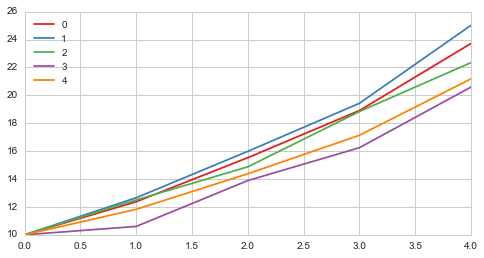

In [31]:
df.plot()

Sim, eu sei, por que perdi tanto tempo com a demonstração acima? Vou utilizá-la em seguida.

### 2.2. Solução Analítica para as Opções Dadas
...




## 3. Replicando o Portfólio

In [2]:
# importa bibliotecas necessarias
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns


## 4. Conclusão

## 5. Reflexões

_Style notebook and change matplotlib defaults_

In [6]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read())

In [7]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set1", 10))